*Роботу виконав </br> Бірук Сергій </br>Група КІ-31мп*


In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [20]:
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


In [21]:
class_names = trainset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

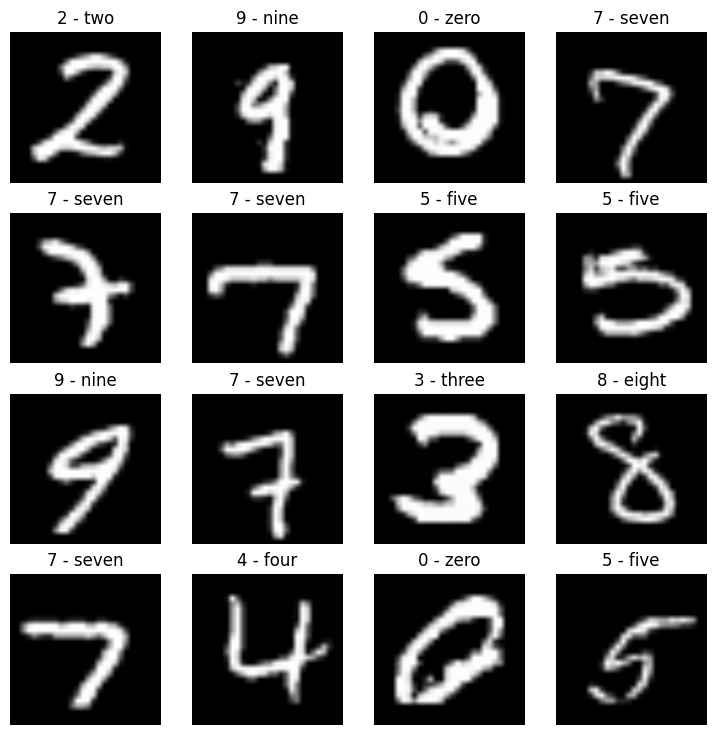

In [22]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [23]:
# Divide the dataset into training, validation, and test sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_dataloader = DataLoader(val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(testset,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 750 batches of 64
Length of valid dataloader: 188 batches of 64
Length of test dataloader: 157 batches of 64


In [25]:
from tqdm import tqdm

In [26]:
# Training loop
def train_loop(model, num_epochs=10, loss_fn=nn.CrossEntropyLoss(), optimizer=None):
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(num_epochs):
      # Training
      model.train()
      running_loss = 0.0
      correct_train = 0
      total_train = 0

      for inputs, labels in tqdm(train_dataloader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          total_train += labels.size(0)
          correct_train += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_dataloader)
      train_accuracy = 100 * correct_train / total_train
      train_losses.append(train_loss)
      train_accs.append(train_accuracy)

      # Validation
      model.eval()
      running_loss = 0.0
      correct_val = 0
      total_val = 0

      with torch.no_grad():
          for inputs, labels in valid_dataloader:
              inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
              outputs = model(inputs)
              loss = loss_fn(outputs, labels)
              running_loss += loss.item()

              _, predicted = torch.max(outputs.data, 1)
              total_val += labels.size(0)
              correct_val += (predicted == labels).sum().item()

      val_loss = running_loss / len(valid_dataloader)
      val_accuracy = 100 * correct_val / total_val
      val_losses.append(val_loss)
      val_accs.append(val_accuracy)

      print(f"Epoch [{epoch + 1}/{num_epochs}] - "
            f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
            f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

  return train_accs, train_losses, val_accs, val_losses


In [27]:
def plot_model(train_accs, val_accs, train_losses, val_losses):
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(train_accs, label='Train')
  plt.plot(val_accs, label='Validation')
  plt.title('Accuracy vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(train_losses, label='Train')
  plt.plot(val_losses, label='Validation')
  plt.title('Loss vs. Epoch')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.show()

In [12]:
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [14]:
model = ResNet(ResNetBlock, [3, 4, 6, 3]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs, train_losses, val_accs, val_losses = train_loop(model, 15, loss_fn, optimizer)

100%|██████████| 750/750 [13:44<00:00,  1.10s/it]


Epoch [1/15] - Train Loss: 0.1895, Train Accuracy: 94.30% - Validation Loss: 0.1129, Validation Accuracy: 96.60%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [2/15] - Train Loss: 0.0575, Train Accuracy: 98.17% - Validation Loss: 0.0571, Validation Accuracy: 98.26%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [3/15] - Train Loss: 0.0450, Train Accuracy: 98.60% - Validation Loss: 0.0412, Validation Accuracy: 98.76%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [4/15] - Train Loss: 0.0400, Train Accuracy: 98.82% - Validation Loss: 0.0828, Validation Accuracy: 97.55%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [5/15] - Train Loss: 0.0362, Train Accuracy: 98.82% - Validation Loss: 0.0343, Validation Accuracy: 99.08%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [6/15] - Train Loss: 0.0303, Train Accuracy: 98.97% - Validation Loss: 0.0366, Validation Accuracy: 98.78%


100%|██████████| 750/750 [13:37<00:00,  1.09s/it]


Epoch [7/15] - Train Loss: 0.0268, Train Accuracy: 99.16% - Validation Loss: 0.0399, Validation Accuracy: 98.77%


100%|██████████| 750/750 [13:37<00:00,  1.09s/it]


Epoch [8/15] - Train Loss: 0.0263, Train Accuracy: 99.19% - Validation Loss: 0.0364, Validation Accuracy: 98.81%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [9/15] - Train Loss: 0.0233, Train Accuracy: 99.29% - Validation Loss: 0.0587, Validation Accuracy: 98.25%


100%|██████████| 750/750 [13:37<00:00,  1.09s/it]


Epoch [10/15] - Train Loss: 0.0208, Train Accuracy: 99.32% - Validation Loss: 0.0290, Validation Accuracy: 99.02%


100%|██████████| 750/750 [13:37<00:00,  1.09s/it]


Epoch [11/15] - Train Loss: 0.0199, Train Accuracy: 99.38% - Validation Loss: 0.0258, Validation Accuracy: 99.18%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [12/15] - Train Loss: 0.0169, Train Accuracy: 99.42% - Validation Loss: 0.0283, Validation Accuracy: 99.16%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [13/15] - Train Loss: 0.0168, Train Accuracy: 99.46% - Validation Loss: 0.0345, Validation Accuracy: 99.08%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [14/15] - Train Loss: 0.0141, Train Accuracy: 99.54% - Validation Loss: 0.0342, Validation Accuracy: 99.04%


100%|██████████| 750/750 [13:36<00:00,  1.09s/it]


Epoch [15/15] - Train Loss: 0.0122, Train Accuracy: 99.65% - Validation Loss: 0.0271, Validation Accuracy: 99.29%


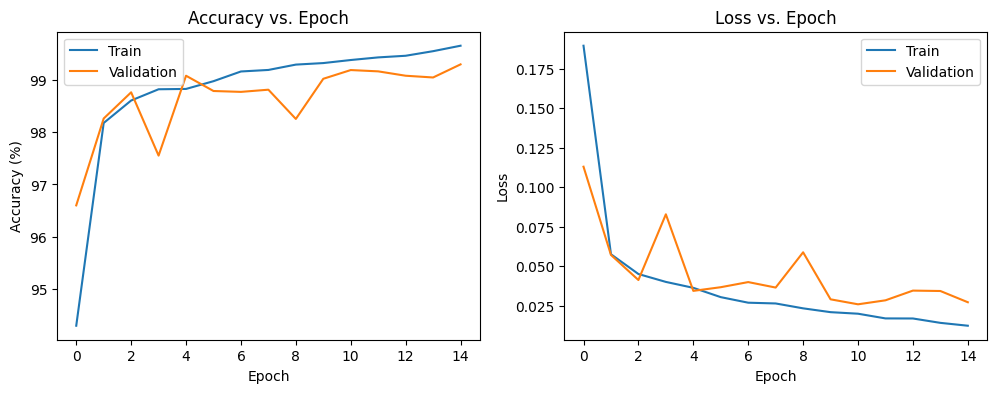

In [15]:
plot_model(train_accs, val_accs, train_losses, val_losses)

In [30]:
# Define the depthwise separable convolution block
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_channels, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

# Define the Xception architecture
class Xception(nn.Module):
    def __init__(self, num_classes=10):
        super(Xception, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.block1 = nn.Sequential(
            DepthwiseSeparableConv2d(64, 128, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.block2 = nn.Sequential(
            DepthwiseSeparableConv2d(128, 256, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.block3 = nn.Sequential(
            DepthwiseSeparableConv2d(256, 728, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.block4 = nn.Sequential(
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
        )
        self.block5 = nn.Sequential(
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
        )
        self.block6 = nn.Sequential(
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
        )
        self.block7 = nn.Sequential(
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
            DepthwiseSeparableConv2d(728, 728),
        )

        self.block8 = nn.Sequential(
            DepthwiseSeparableConv2d(728, 1024, stride=2),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.block9 = nn.Sequential(
            DepthwiseSeparableConv2d(1024, 1536),
            DepthwiseSeparableConv2d(1536, 2048),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = self.block4(x) + x
        x = self.block5(x) + x
        x = self.block6(x) + x
        x = self.block7(x) + x

        x = self.block8(x)
        x = self.block9(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [31]:
model = Xception().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_accs, train_losses, val_accs, val_losses = train_loop(model, 15, loss_fn, optimizer)

100%|██████████| 750/750 [01:49<00:00,  6.88it/s]


Epoch [1/15] - Train Loss: 0.2095, Train Accuracy: 93.57% - Validation Loss: 0.1033, Validation Accuracy: 97.06%


100%|██████████| 750/750 [01:44<00:00,  7.19it/s]


Epoch [2/15] - Train Loss: 0.0853, Train Accuracy: 97.43% - Validation Loss: 0.0529, Validation Accuracy: 98.37%


100%|██████████| 750/750 [01:44<00:00,  7.17it/s]


Epoch [3/15] - Train Loss: 0.0602, Train Accuracy: 98.22% - Validation Loss: 0.0495, Validation Accuracy: 98.58%


100%|██████████| 750/750 [01:44<00:00,  7.20it/s]


Epoch [4/15] - Train Loss: 0.0521, Train Accuracy: 98.46% - Validation Loss: 0.0637, Validation Accuracy: 98.31%


100%|██████████| 750/750 [01:44<00:00,  7.19it/s]


Epoch [5/15] - Train Loss: 0.0435, Train Accuracy: 98.68% - Validation Loss: 0.0497, Validation Accuracy: 98.62%


100%|██████████| 750/750 [01:44<00:00,  7.20it/s]


Epoch [6/15] - Train Loss: 0.0376, Train Accuracy: 98.87% - Validation Loss: 0.0476, Validation Accuracy: 98.58%


100%|██████████| 750/750 [01:43<00:00,  7.22it/s]


Epoch [7/15] - Train Loss: 0.0343, Train Accuracy: 98.92% - Validation Loss: 0.0594, Validation Accuracy: 98.16%


100%|██████████| 750/750 [01:43<00:00,  7.22it/s]


Epoch [8/15] - Train Loss: 0.0305, Train Accuracy: 99.08% - Validation Loss: 0.0410, Validation Accuracy: 98.91%


100%|██████████| 750/750 [01:43<00:00,  7.23it/s]


Epoch [9/15] - Train Loss: 0.0267, Train Accuracy: 99.21% - Validation Loss: 0.0464, Validation Accuracy: 98.67%


100%|██████████| 750/750 [01:45<00:00,  7.08it/s]


Epoch [10/15] - Train Loss: 0.0307, Train Accuracy: 99.10% - Validation Loss: 0.0372, Validation Accuracy: 98.99%


100%|██████████| 750/750 [01:46<00:00,  7.07it/s]


Epoch [11/15] - Train Loss: 0.0203, Train Accuracy: 99.40% - Validation Loss: 0.0413, Validation Accuracy: 98.92%


100%|██████████| 750/750 [01:46<00:00,  7.03it/s]


Epoch [12/15] - Train Loss: 0.0236, Train Accuracy: 99.26% - Validation Loss: 0.0334, Validation Accuracy: 99.04%


100%|██████████| 750/750 [01:45<00:00,  7.08it/s]


Epoch [13/15] - Train Loss: 0.0188, Train Accuracy: 99.41% - Validation Loss: 0.0396, Validation Accuracy: 98.92%


100%|██████████| 750/750 [01:45<00:00,  7.12it/s]


Epoch [14/15] - Train Loss: 0.0177, Train Accuracy: 99.47% - Validation Loss: 0.0327, Validation Accuracy: 99.08%


100%|██████████| 750/750 [01:45<00:00,  7.13it/s]


Epoch [15/15] - Train Loss: 0.0147, Train Accuracy: 99.52% - Validation Loss: 0.0455, Validation Accuracy: 98.80%


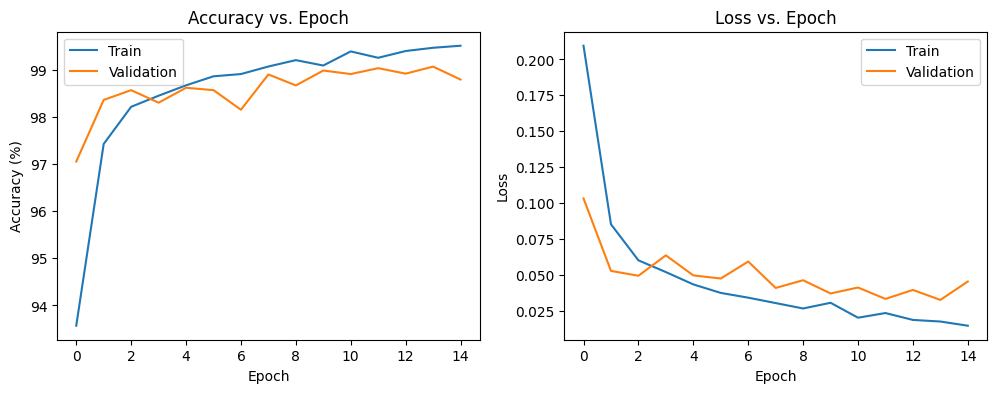

In [32]:
plot_model(train_accs, val_accs, train_losses, val_losses)

У цій роботі ми реалізували дві популярні архітектури глибокого навчання - ResNet та Xception - за допомогою PyTorch. Для навчання ми використовували набір даних MNIST. Ми також виконали попередню обробку наборів даних і розділили їх на навчальні, валідаційні та тестові.
Ми навчали моделі за допомогою оптимізатора Adam зі швидкістю навчання 0.001, і навчали їх протягом 15 епох. Ми відстежували втрати при навчанні та точність, щоб оцінити продуктивність моделей.
Загалом, ми виявили, що всі три архітектури змогли досягти високої точності на наборах даних, причому ResNet показала найкращі результати отримавши 99.29% accuracy, а модель AlexNet із попередньої лабораторної роботи показала  результат в 99,27%, і звісно найгірше показала модель Xception із показником 99.08%. Хоча ResNet і показала кращий результат, ніж Xception, але підбір гіперпараметрів здатний змінити результат. Також звернимо увагу на час навчання моделей. Одна епоха на ResNet навчається 13:37 за, а Xception за 1:45.

На закінчення, ця робота демонструє потужність і гнучкість архітектур глибокого навчання для задач класифікації зображень, а також є відправною точкою для подальших експериментів і оптимізації.